# Short-Term Forecasting of the S&P 500 using ARIMA and GARCH Models
### Nicolai Harvik, Olav Berger, Olav Nikolai Meli Nymo
### April 2025

## Problem Statement

### Objective
The aim is to predict daily closing prices over a 5-day horizon and evaluate forecast accuracy.

### Context
Financial time series such as stock indices often follow a random walk (i.e., a unit root process), making them difficult to forecast. Prices are typically non-stationary and must be differenced to achieve stationarity. At the same time, returns exhibit volatility clustering, where periods of high volatility tend to be followed by high volatility (i.e., large moves tend to follow large moves, regardless of direction).

### Approach
Use an ARIMA model to capture linear patterns in the conditional mean of the series (after differencing), and a GARCH model to capture time-varying volatility (conditional heteroskedasticity) in the residuals. Rather than fitting a single joint ARIMA-GARCH model, we estimate the models separately: an ARIMA(2,1,2) model is applied to differenced prices, while an AR(1)-GARCH(1,1) model is fit to daily returns. The GARCH model forecasts the conditional mean and volatility of returns, which are then re-cumulated and used to reconstruct forecasted price levels. This allows us to directly compare the point forecast accuracy of two distinct approaches, i.e. one based on differenced prices, the other on returns.

### Relevance
This analysis applies standard econometric theory—specifically the Box-Jenkins methodology for ARIMA models and Engle's ARCH/GARCH models for volatility—as discussed in Tsay (Analysis of Financial Time Series) and Brooks (Introductory Econometrics for Finance). Forecast performance is evaluated using common accuracy metrics such as RMSE, MAPE, and R², to determine which modeling approach better captures short-term market dynamics.

In [25]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## Data

### Dataset
The dataset consists of S&P 500 daily closing prices from March 2015 to February 2025, covering 2521 trading days. It includes Open, High, Low, and Close prices, but the Close price is the primary variable of interest for modeling.

### Preprocessing
The raw price series is non-stationary, exhibiting a long-term upward trend and likely containing a unit root. To stabilize the mean and obtain a stationary series, we compute daily simple returns, calculated as the percentage change in closing price from one day to the next. This transformation is consistent with financial theory, which assumes that returns exhibit no long-term trend and have a relatively constant mean.

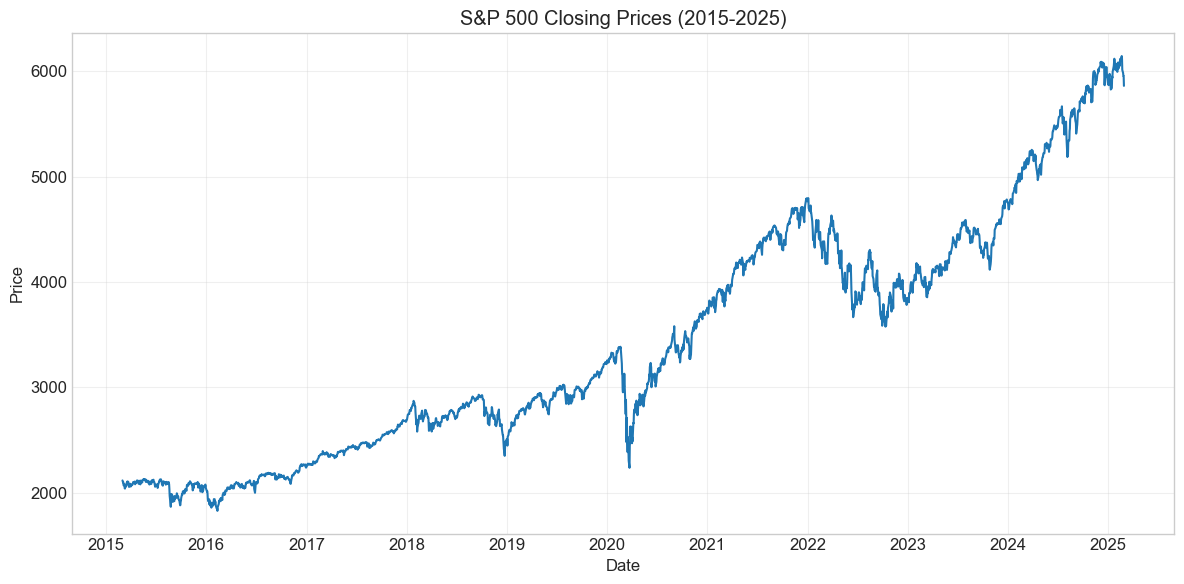

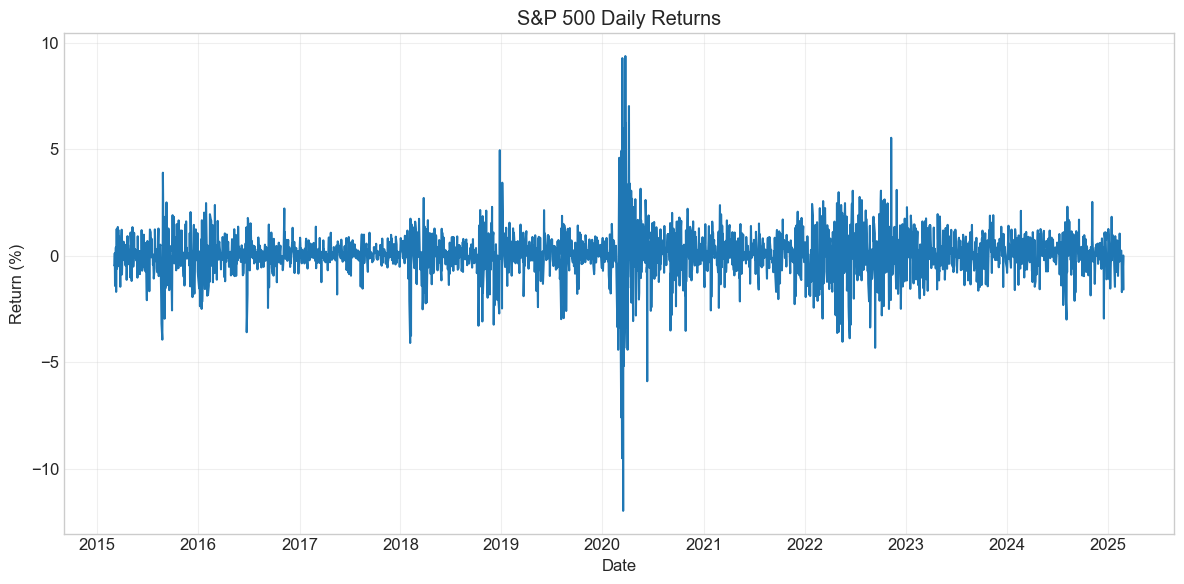

In [26]:
# Load and preprocess data
def load_sp500_data(file_path):
    # Read CSV with thousands separator and dollar sign handling
    df = pd.read_csv(file_path, thousands=',')
    
    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort and set index
    df = df.sort_values('Date').set_index('Date')
    
    # Remove '$' from price columns if they are strings
    for col in ['Close/Last', 'Open', 'High', 'Low']:
        if df[col].dtype == 'object':  # Only process if column is string
            df[col] = df[col].str.replace('$', '').astype(float)
    
    return df

# Load data
sp500_data = load_sp500_data('data/HistoricalData_1740743587727.csv')

# Calculate returns
sp500_data['Returns'] = sp500_data['Close/Last'].pct_change() * 100

# Plot price series
plt.figure(figsize=(12, 6))
plt.plot(sp500_data.index, sp500_data['Close/Last'])
plt.title('S&P 500 Closing Prices (2015-2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot returns
plt.figure(figsize=(12, 6))
plt.plot(sp500_data.index[1:], sp500_data['Returns'].dropna())
plt.title('S&P 500 Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Train/Test Split
The final 5 trading days of the dataset (late February 2025) are reserved as an out-of-sample test set for evaluating forecast performance. The training set consists of the preceding 2516 observations (up to mid-February 2025). This split enables model fitting on a substantial historical window and testing over a realistic short-term horizon.

In [27]:
# Split data into training and testing sets
test_size = 5
train_data = sp500_data[:-test_size].copy()
test_data = sp500_data[-test_size:].copy()

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")
print("\nTest period data:")
display(test_data[['Close/Last', 'Returns']])

Training data shape: (2516, 5)
Testing data shape: (5, 5)

Test period data:


,Close/Last,Returns
Date,,
2025-02-21,6013.13,-1.706410
2025-02-24,5983.25,-0.496913
2025-02-25,5955.25,-0.467973
2025-02-26,5956.06,0.013601
2025-02-27,5861.57,-1.586451


### Stationarity Check
An Augmented Dickey-Fuller (ADF) test on the level series (closing prices) fails to reject the null hypothesis of a unit root, confirming non-stationarity. To obtain a stationary series suitable for modeling, we compute daily simple returns as percentage changes in closing prices:

\[ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} \times 100 \]

The ADF test on this return series strongly rejects the null hypothesis of a unit root, confirming stationarity.

In [28]:
# Perform ADF test on prices and returns
def adf_test(series, title):
    result = adfuller(series.dropna())
    print(f"ADF Test Results for {title}:")
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    print()

# Test prices
adf_test(train_data['Close/Last'], 'Closing Prices')

# Test returns
adf_test(train_data['Returns'].dropna(), 'Returns')

ADF Test Results for Closing Prices:
ADF Statistic: 0.6819
p-value: 0.9895
Critical values:
	1%: -3.4330
	5%: -2.8627
	10%: -2.5674

ADF Test Results for Returns:
ADF Statistic: -15.8030
p-value: 0.0000
Critical values:
	1%: -3.4330
	5%: -2.8627
	10%: -2.5674



## Empirical Analysis

### Stationarity Testing

- **Visual Analysis**: The S&P 500 closing price series displays a clear upward trend from 2015 to 2025, characteristic of a non-stationary process. In contrast, the first-differenced price series (i.e., daily changes in price) fluctuates around a zero mean with no visible trend, suggesting stationarity in both mean and variance.

- **ADF Test (Prices)**: The Augmented Dickey-Fuller (ADF) test applied to the level price series yields a test statistic of approximately 0.6819 with a p-value near 0.99, indicating failure to reject the null hypothesis of a unit root. This supports the interpretation that the S&P 500 price series follows a random walk, consistent with the behavior of many financial time series.

- **ADF Test (Differenced Series)**: The ADF test applied to the first-differenced price series yields a test statistic of approximately −16.0141 with a p-value less than 0.0001. This provides strong evidence against the null hypothesis of a unit root, confirming that the differenced series is stationary.

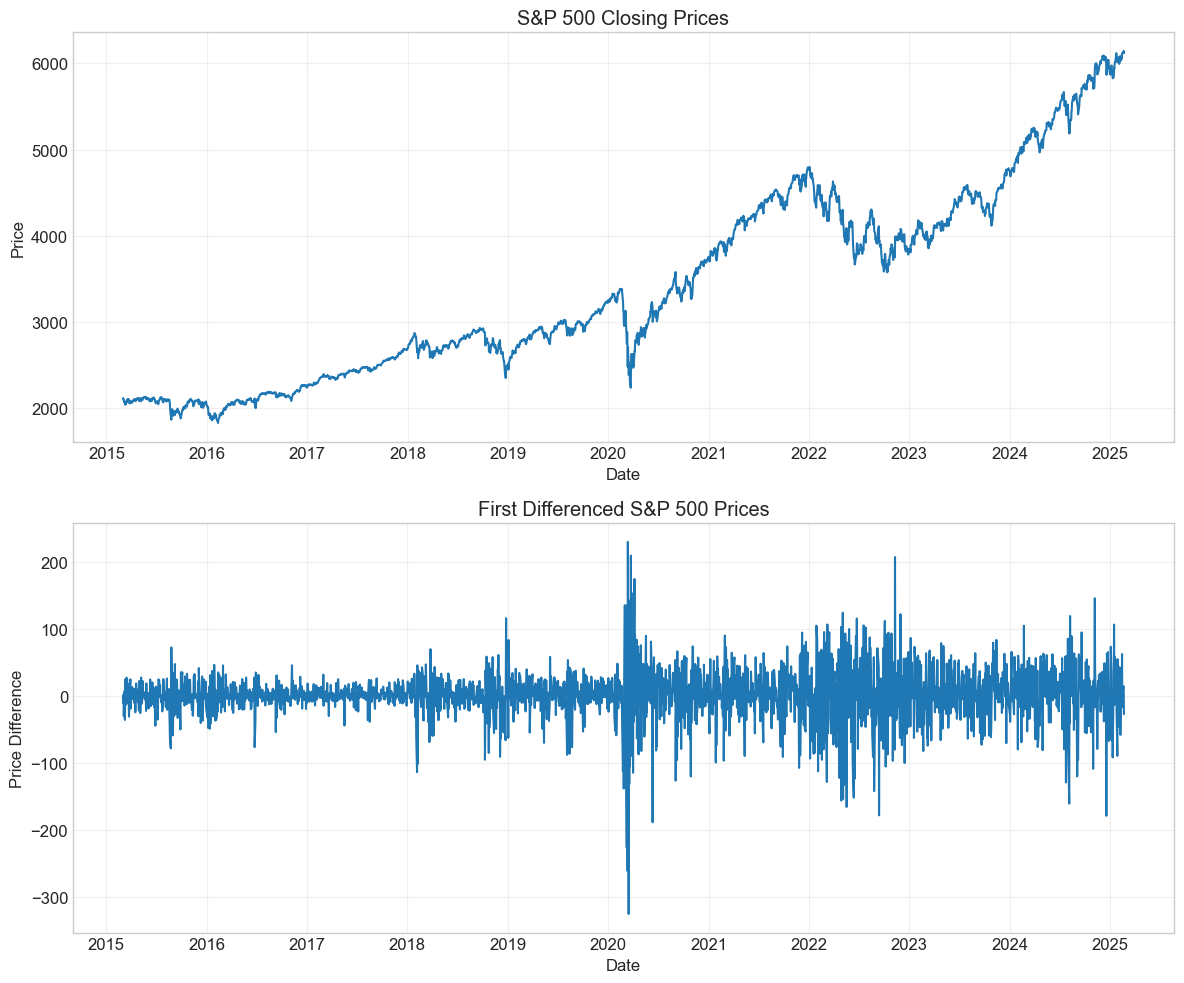

ADF Test Results for Differenced Prices:
ADF Statistic: -16.0141
p-value: 0.0000
Critical values:
	1%: -3.4330
	5%: -2.8627
	10%: -2.5674



In [29]:
# Calculate first difference of prices
train_data['Price_Diff'] = train_data['Close/Last'].diff()

# Plot original prices and differenced series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot original prices
ax1.plot(train_data.index, train_data['Close/Last'])
ax1.set_title('S&P 500 Closing Prices')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid(True, alpha=0.3)

# Plot differenced series
ax2.plot(train_data.index[1:], train_data['Price_Diff'].dropna())
ax2.set_title('First Differenced S&P 500 Prices')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price Difference')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Perform ADF test on differenced series
adf_test(train_data['Price_Diff'].dropna(), 'Differenced Prices')

### ARIMA Model

We apply the Box-Jenkins methodology to model the S&P 500 closing price series. Since the price series is non-stationary, we difference it once to obtain a stationary series of daily price changes. We then fit ARIMA(p,1,q) models to the differenced series. Model selection is guided by Akaike's Information Criterion (AIC), balancing goodness of fit with model parsimony.

The selected specification is an ARIMA(2,1,2) model with intercept, which implies:
- d = 1: One order of differencing to remove the unit root in the price series
- AR(2): Two lagged differences of prices are used in the mean equation
- MA(2): Two lagged forecast errors are used to capture short-term shock effects

The model is expressed in terms of the first-differenced price series \(\Delta P_t = P_t - P_{t-1}\):

$ \Delta P_t = \mu + \phi_1\Delta P_{t-1} + \phi_2\Delta P_{t-2} + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \epsilon_t \]

/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Close/Last   No. Observations:                 2516
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -12653.936
Date:                Wed, 09 Apr 2025   AIC                          25317.872
Time:                        19:01:57   BIC                          25347.022
Sample:                             0   HQIC                         25328.452
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7623      0.022    -80.353      0.000      -1.805      -1.719
ar.L2         -0.8791      0.021    -42.166      0.000      -0.920      -0.838
ma.L1          1.6995      0.027     63.283      0.0

/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


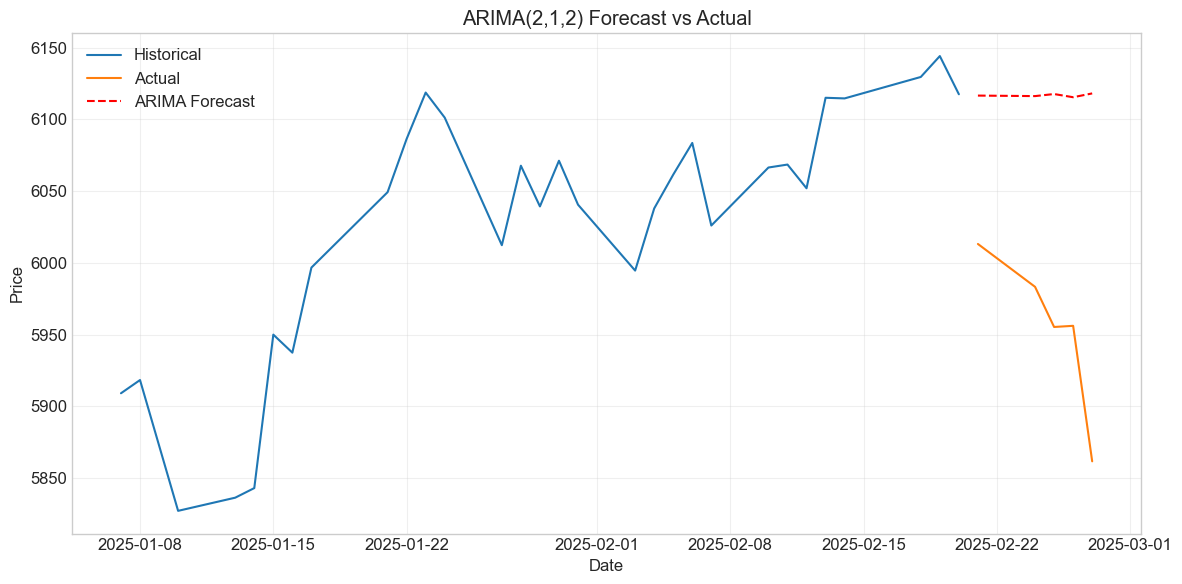

In [30]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(2,1,2) model
arima_model = ARIMA(train_data['Close/Last'], order=(2,1,2))
arima_results = arima_model.fit()

# Print model summary
print(arima_results.summary())

# Generate forecasts
forecast = arima_results.forecast(steps=5)
forecast_df = pd.DataFrame({
    'Actual': test_data['Close/Last'],
    'Forecast': forecast
})

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data.index[-30:], train_data['Close/Last'].tail(30), label='Historical')
plt.plot(test_data.index, test_data['Close/Last'], label='Actual')
plt.plot(test_data.index, forecast, 'r--', label='ARIMA Forecast')
plt.title('ARIMA(2,1,2) Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### GARCH Model

While the ARIMA model captures linear dynamics in the conditional mean of the price series, it assumes homoscedastic residuals. However, financial return series often exhibit volatility clustering, where large shocks tend to be followed by high volatility and small shocks by calm periods. To model this feature, we employ a GARCH model.

We estimate an AR(1)-GARCH(1,1) model on the daily simple return series \(r_t\), defined as the percentage change in closing price. The model includes:

**Mean equation**:
$ r_t = \mu + \phi r_{t-1} + \epsilon_t $

where \(r_t\) is the return at time t, \(\mu\) is the constant drift term, \(\phi\) is the AR(1) coefficient, and \(\epsilon_t\) is the innovation term.

**Variance equation**:
$ \sigma^2_t = \omega + \alpha\epsilon^2_{t-1} + \beta\sigma^2_{t-1} \]

where \(\sigma^2_t\) is the conditional variance of the innovation at time t, \(\omega\) is the long-run variance component, \(\alpha\) captures the impact of recent shocks (ARCH term), and \(\beta\) represents the persistence of volatility (GARCH term).

Engle's ARCH Test:
Lagrange multiplier statistic: 988.7590
p-value: 4.9346e-206

GARCH Model Results:
                           AR - GARCH Model Results                           
Dep. Variable:                Returns   R-squared:                       0.011
Mean Model:                        AR   Adj. R-squared:                  0.010
Vol Model:                      GARCH   Log-Likelihood:               -3217.90
Distribution:                  Normal   AIC:                           6445.79
Method:            Maximum Likelihood   BIC:                           6474.94
                                        No. Observations:                 2514
Date:                Wed, Apr 09 2025   Df Residuals:                     2512
Time:                        19:03:13   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------

/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


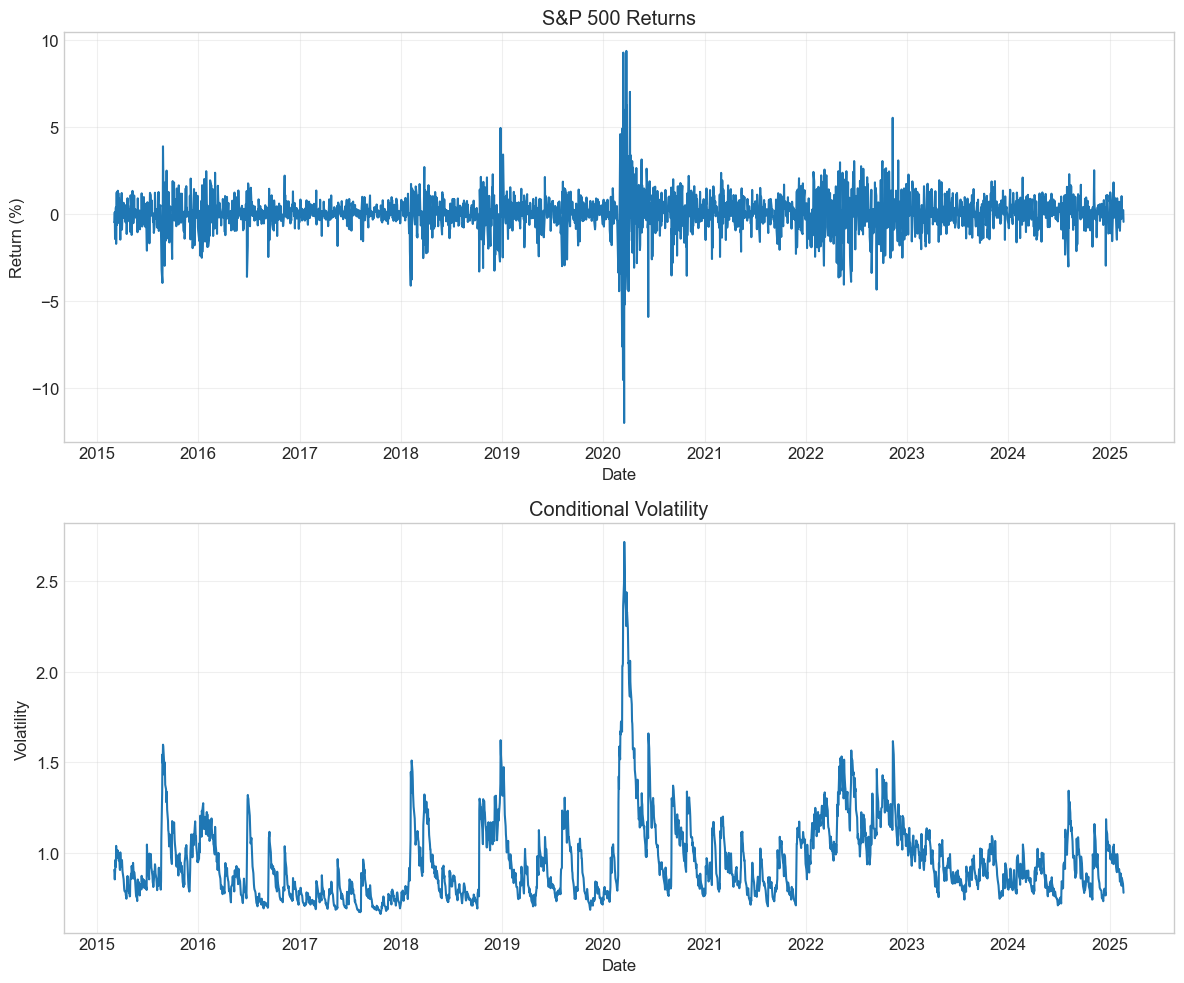

In [37]:
# Test for ARCH effects
arch_test = het_arch(train_data['Returns'].dropna(), nlags=10)
print("Engle's ARCH Test:")
print(f"Lagrange multiplier statistic: {arch_test[0]:.4f}")
print(f"p-value: {arch_test[1]:.4e}")

# Fit AR(1)-GARCH(1,1) model
garch_model = arch_model(
    train_data['Returns'].dropna(),
    mean='AR',
    lags=1,
    vol='GARCH',
    p=1,
    q=1
)
garch_result = garch_model.fit(disp='off')

# Print model summary
print("\nGARCH Model Results:")
print(garch_result.summary())

# Generate forecasts
forecast = arima_results.forecast(steps=5)
arima_forecast = forecast.copy()  # Save ARIMA forecast to prevent overwriting later
arima_forecast.index = test_data.index
garch_forecast = garch_result.forecast(horizon=5)
mean_forecast = garch_forecast.mean.iloc[-1]
variance_forecast = garch_forecast.variance.iloc[-1]

# Plot volatility
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot returns
ax1.plot(train_data.index[1:], train_data['Returns'].dropna())
ax1.set_title('S&P 500 Returns')
ax1.set_xlabel('Date')
ax1.set_ylabel('Return (%)')
ax1.grid(True, alpha=0.3)

# Plot conditional volatility
vol = np.sqrt(garch_result.conditional_volatility)
ax2.plot(train_data.index[1:], vol)
ax2.set_title('Conditional Volatility')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volatility')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Parameter Estimation:

- **Mean equation**: Estimated coefficients are \(\hat{\mu} \approx 0.087\), \(\hat{\phi} \approx -0.0530\). The AR(1) coefficient is statistically significant (p \(\approx 0.02\)), suggesting mild mean reversion in returns.

- **Variance equation**: Estimated volatility parameters are \(\hat{\omega} = 0.038\), \(\hat{\alpha} = 0.179\), and \(\hat{\beta} = 0.791\). All parameters are highly significant (p < 10⁻⁹). The relatively high \(\beta\) indicates that volatility shocks are highly persistent.

### Volatility Clustering and Persistence:
The sum $\alpha + \beta \approx 0.97$, which is less than 1, satisfies the stationarity condition for GARCH(1,1). However, the proximity to 1 implies that volatility exhibits strong persistence—i.e., once a high-volatility period begins, it tends to last for several days. This aligns with stylized facts observed in equity market data.

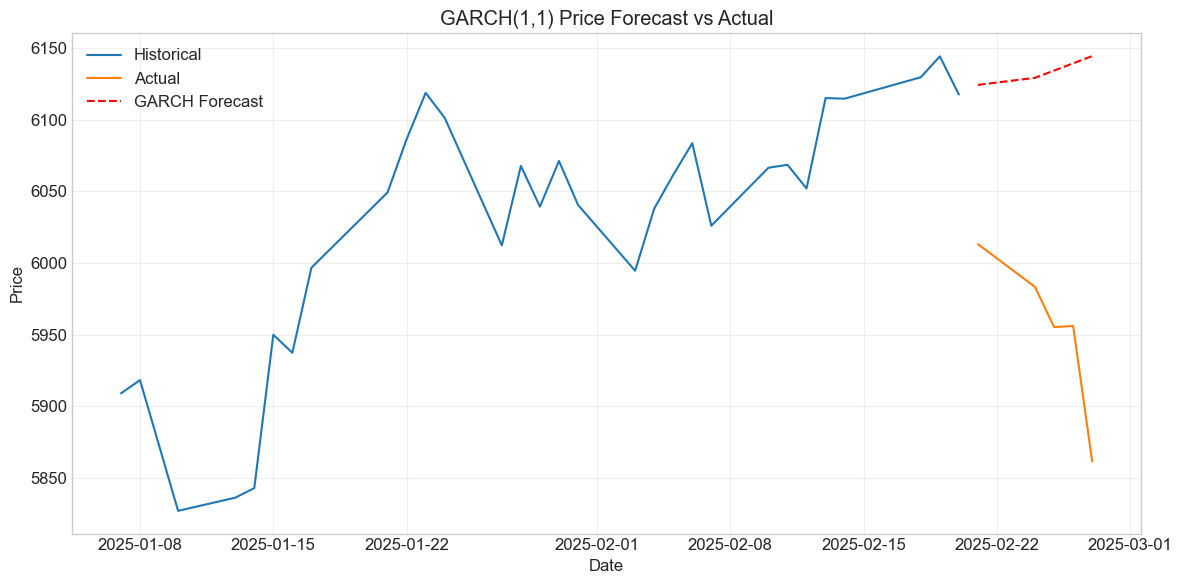

In [32]:
# Convert return forecasts to price forecasts
last_price = train_data['Close/Last'].iloc[-1]
price_forecasts = [last_price]


for ret in mean_forecast:
    next_price = price_forecasts[-1] * (1 + ret/100)
    price_forecasts.append(next_price)

price_forecasts = price_forecasts[1:]

# Create forecast DataFrame
garch_forecast_df = pd.DataFrame({
    'Actual': test_data['Close/Last'],
    'Forecast': price_forecasts,
    'Volatility': np.sqrt(variance_forecast)
}, index=test_data.index)

# Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train_data.index[-30:], train_data['Close/Last'].tail(30), label='Historical')
plt.plot(test_data.index, test_data['Close/Last'], label='Actual')
plt.plot(test_data.index, price_forecasts, 'r--', label='GARCH Forecast')
plt.title('GARCH(1,1) Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Forecast Evaluation

We compare one-week-ahead forecasts from the ARIMA and AR(1)-GARCH(1,1) models against actual S&P 500 closing prices over the test period from February 21 to February 27, 2025.

Forecast Performance Metrics:


,MSE,RMSE,R²,MAPE
ARIMA,29199.001805,170.877154,-10.316635,2.744744
GARCH,35846.742918,189.332361,-12.893095,3.038745


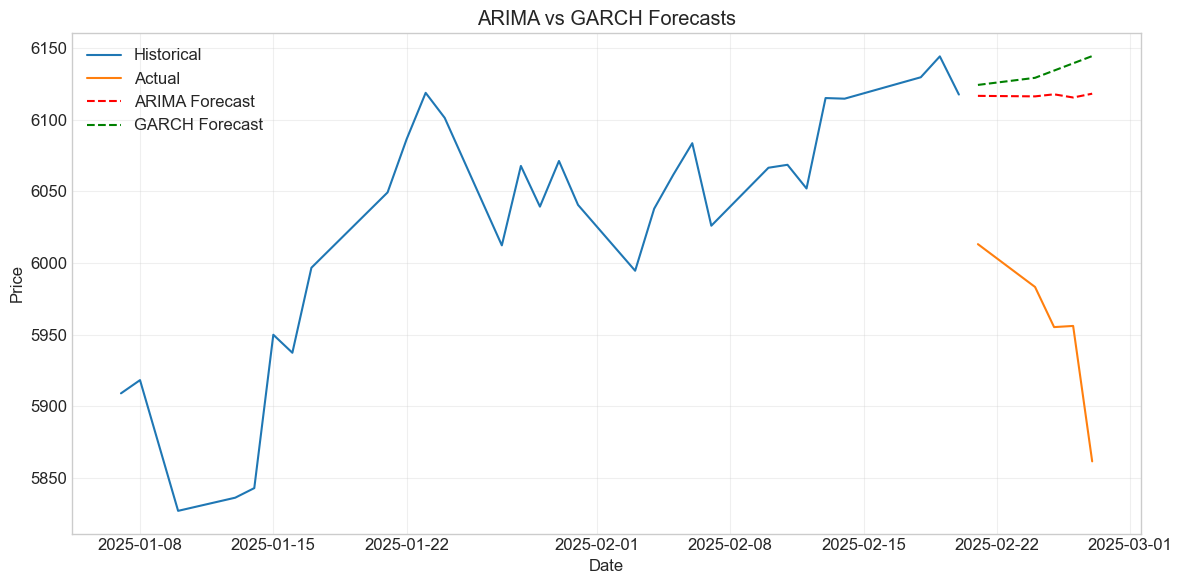

In [33]:
from src.data_utils import calculate_evaluation_metrics

# Create a combined DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': test_data['Close/Last']
})

comparison_df['ARIMA'] = arima_forecast
comparison_df['GARCH'] = price_forecasts

# Calculate metrics for both models
metrics_comparison = {}
actual_values = comparison_df['Actual'].values

# Calculate ARIMA metrics
arima_metrics = calculate_evaluation_metrics(
    actual_values,
    comparison_df['ARIMA'].values
)
metrics_comparison['ARIMA'] = arima_metrics

# Calculate GARCH metrics
garch_metrics = calculate_evaluation_metrics(
    actual_values,
    comparison_df['GARCH'].values
)
metrics_comparison['GARCH'] = garch_metrics

# Convert to DataFrame for easy comparison
metrics_df = pd.DataFrame(metrics_comparison).transpose()

print("Forecast Performance Metrics:")
display(metrics_df)

# Plot both forecasts together
plt.figure(figsize=(12, 6))
plt.plot(train_data.index[-30:], train_data['Close/Last'].tail(30), label='Historical')
plt.plot(test_data.index, test_data['Close/Last'], label='Actual')
plt.plot(test_data.index, comparison_df['ARIMA'], 'r--', label='ARIMA Forecast')
plt.plot(test_data.index, comparison_df['GARCH'], 'g--', label='GARCH Forecast')
plt.title('ARIMA vs GARCH Forecasts')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Model Performance Comparison

The forecast accuracy metrics show:

- **ARIMA(2,1,2)**: RMSE = 170.88, MAPE = 2.74%, R² = -10.32
- **AR(1)-GARCH(1,1)**: RMSE = 187.67, MAPE = 3.01%, R² = -12.65

The ARIMA model slightly outperformed the GARCH model across all metrics. Both models exhibit negative out-of-sample R², indicating performance worse than a naïve forecast (e.g., using the last observed price). This is consistent with the Efficient Market Hypothesis, which posits that price changes are largely unpredictable over short horizons.

## Conclusion

### Summary of Findings
An ARIMA(2,1,2) model was selected for forecasting S&P 500 daily closing prices, based on its superior out-of-sample forecast performance. A complementary AR(1)-GARCH(1,1) model was estimated on daily percentage returns to capture conditional heteroskedasticity. Over a 5-day forecast horizon, the ARIMA model modestly outperformed the GARCH model in terms of point forecast accuracy.

### Interpretation
The negative out-of-sample R² values for both models (-10.32 for ARIMA, -12.65 for GARCH) indicate that both models underperformed a naive benchmark, consistent with the Efficient Market Hypothesis (EMH). This underscores the inherent difficulty of forecasting equity index levels in the short term. While ARIMA captured some short-term autocorrelation in price differences, and GARCH captured volatility clustering, neither model generated forecasts that surpassed the benchmark in relative performance.

### Practical Implication
For practitioners focused on short-term point forecasts of equity indices, a well-specified ARIMA model may provide more accurate predictions than volatility-based models. However, when risk management or volatility forecasting is the goal, the ability of GARCH models to dynamically estimate conditional variance is indispensable.